In [1]:
ANSWER_MODEL = "gemma2"
JUDGE_MODEL = "llama3.1"
GENERATOR_MODEL = "llama3.1"

In [2]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.utils import embedding_functions
import ollama
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/Users/liulko-alex/Studying/llm_proj/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
client = chromadb.Client()
collection = client.create_collection("recipes", get_or_create=True)

In [4]:
dataset = load_dataset("AkashPS11/recipes_data_food.com", split="train")
embedder = SentenceTransformer("all-MiniLM-L6-v2")

In [5]:
for item in dataset[0]:
    print(item)

RecipeId
Barcode
Name
AuthorId
AuthorName
CookTime
PrepTime
TotalTime
DatePublished
Description
Images
RecipeCategory
Keywords
RecipeIngredientQuantities
RecipeIngredientParts
AggregatedRating
ReviewCount
Calories
FatContent
SaturatedFatContent
CholesterolContent
SodiumContent
CarbohydrateContent
FiberContent
SugarContent
ProteinContent
RecipeServings
RecipeYield
RecipeInstructions


In [6]:
texts = [item for item in dataset["RecipeInstructions"][:500]]  # возьми первые 500 для теста
embeddings = embedder.encode(texts)

collection.add(
    documents=texts,
    embeddings=embeddings,
    ids=[f"recipe-{i}" for i in range(len(texts))]
)

In [7]:
def rag_query(query: str, top_k: int = 3, model: str = ANSWER_MODEL):
    query_emb = embedder.encode([query])[0]
    results = collection.query(query_embeddings=[query_emb], n_results=top_k)
    context = "\n\n".join(results["documents"][0])
    # print(context)
    prompt = f"""
Ты — помощник, который отвечает на вопросы о рецептах.
Используй приведённые рецепты как контекст:

{context}

Вопрос: {query}
Ответ:
"""
    response = ollama.chat(model=model, messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"]

In [8]:
def plain_query(query: str, model: str = ANSWER_MODEL):
    prompt = f"""
Ты — дружелюбный кулинарный помощник.
Опираясь на свои внутренние знания и общие кулинарные принципы,
ответь на вопрос как можно точнее и практичнее.

Вопрос: {query}
Ответ:
"""
    response = ollama.chat(model=model, messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"]

In [9]:
base_scenarios = [
    {
        "id": "abstract-dessert",
        "description": "Нестандартный десерт для гостей",
        "question": "Придумай оригинальный десерт с шоколадом и цитрусами, который удивит гостей.",
    },
    {
        "id": "fridge-leftovers",
        "description": "Готовим из того, что есть",
        "question": (
            "В холодильнике есть куриная грудка, замороженный шпинат, консервированная фасоль, лук и специи. "
            "Предложи полноценный ужин, используя только эти продукты."
        ),
    },
    {
        "id": "multicooker-only",
        "description": "Ограничение по технике",
        "question": "Составь рецепт сытного завтрака, который можно приготовить исключительно в мультиварке.",
    },
]

In [10]:
scenario_templates = [
    {
        "id_prefix": "abstract-dessert",
        "description": "Нестандартный десерт",
        "prompt": (
            "Сгенерируй {n} разнообразных вопросов о создании необычных десертов. "
            "К каждому добавь уточнения про вкусовые сочетания или впечатление для гостей."
        ),
    },
    {
        "id_prefix": "fridge-leftovers",
        "description": "Что приготовить из остатков",
        "prompt": (
            "Сгенерируй {n} вопросов вида 'что приготовить из того, что есть в холодильнике'. "
            "Каждый вопрос должен перечислять конкретные 4-6 ингредиентов."
        ),
    },
    {
        "id_prefix": "multicooker-only",
        "description": "Ограничение по технике",
        "prompt": (
            "Сгенерируй {n} вопросов, где пользователь просит рецепт для конкретного кухонного прибора "
            "(например, мультиварка, аэрогриль, рисоварка). Указывай прибор явно."
        ),
    },
]

In [11]:
def generate_scenarios_per_template(templates, n_per_type: int = 5, model: str = GENERATOR_MODEL):
    generated = []
    for template in tqdm(templates, desc="Генерация сценариев", unit="тип"):
        prompt = (
            "Ответь в JSON формате с ключом 'questions' (список строк).\n"
            + template["prompt"].format(n=n_per_type)
        )
        response = ollama.chat(model=model, messages=[{"role": "user", "content": prompt}])
        content = response["message"]["content"].strip()
        try:
            payload = json.loads(content)
            questions = payload.get("questions", [])
        except json.JSONDecodeError:
            questions = [q.strip() for q in content.split("\n") if q.strip()]

        for idx, question in enumerate(questions):
            question_text = question if isinstance(question, str) else json.dumps(question, ensure_ascii=False)
            generated.append(
                {
                    "id": f"{template['id_prefix']}-{idx+1}-{hash(question_text) % 9999}",
                    "description": template["description"],
                    "question": question_text,
                }
            )
        print(f"[{template['id_prefix']}] получено {len(questions)} вопросов")
    return generated

In [12]:
def build_scenarios(n_auto_per_type: int = 25):
    auto = generate_scenarios_per_template(scenario_templates, n_per_type=n_auto_per_type)
    return base_scenarios + auto

In [13]:
scenarios = build_scenarios(25)
print(f"Сценариев готово: {len(scenarios)} (базовых: {len(base_scenarios)}, авто: {len(scenarios) - len(base_scenarios)})")

Генерация сценариев:  33%|███▎      | 1/3 [01:07<02:15, 67.76s/тип]

[abstract-dessert] получено 24 вопросов


Генерация сценариев:  67%|██████▋   | 2/3 [01:31<00:42, 42.10s/тип]

[fridge-leftovers] получено 23 вопросов


Генерация сценариев: 100%|██████████| 3/3 [01:46<00:00, 35.46s/тип]

[multicooker-only] получено 24 вопросов
Сценариев готово: 74 (базовых: 3, авто: 71)


In [14]:
def judge_responses(question: str, rag_answer: str, plain_answer: str, model: str = JUDGE_MODEL):
    judge_prompt = f"""
Ты выступаешь в роли независимого шеф-эксперта.
Сравни два ответа на один и тот же вопрос по критериям:
1. Точность и пригодность рецепта.
2. Соответствие ограничениям из вопроса (ингредиенты, техника).
3. Структура и полезность объяснений.

Вопрос: {question}

Ответ RAG:
{rag_answer}

Ответ Без RAG:
{plain_answer}

Выбери только один вариант: "rag", "plain" или "tie" (ничья).
Ответь строго в JSON:
{{
  "winner": "rag|plain|tie",
  "reason": "краткое объяснение"
}}
"""

    response = ollama.chat(model=model, messages=[{"role": "user", "content": judge_prompt}])
    content = response["message"]["content"].strip()
    try:
        verdict = json.loads(content)
    except json.JSONDecodeError:
        # fallback: try to infer winner keyword
        lowered = content.lower()
        if "rag" in lowered and "plain" not in lowered:
            winner = "rag"
        elif "plain" in lowered and "rag" not in lowered:
            winner = "plain"
        else:
            winner = "tie"
        verdict = {"winner": winner, "reason": content}
    return verdict

In [15]:
def run_comparisons(scenarios, answer_model: str = ANSWER_MODEL, judge_model: str = JUDGE_MODEL, top_k: int = 3):
    records = []
    for scenario in scenarios:
        question = scenario["question"]
        rag_ans = rag_query(question, top_k=scenario.get("top_k", top_k), model=answer_model)
        plain_ans = plain_query(question, model=answer_model)
        verdict = judge_responses(question, rag_ans, plain_ans, model=judge_model)

        records.append(
            {
                "scenario_id": scenario["id"],
                "description": scenario["description"],
                "question": question,
                "rag_answer": rag_ans,
                "plain_answer": plain_ans,
                "winner": verdict.get("winner", "unknown"),
                "judge_reason": verdict.get("reason", ""),
            }
        )
    return pd.DataFrame(records)

In [16]:
results_df = run_comparisons(scenarios)
results_df.head()

,scenario_id,description,question,rag_answer,plain_answer,winner,judge_reason
0,abstract-dessert,Нестандартный десерт для гостей,Придумай оригинальный десерт с шоколадом и цит...,## Шоколадный апельсиновый чизкейк с бисквитны...,"## Шоколадный тарт ""Огненные апельсины"" \n\nЭт...",rag,Ответ RAG имеет более детальное и полное описа...
1,fridge-leftovers,"Готовим из того, что есть","В холодильнике есть куриная грудка, замороженн...",Предлагаю приготовить **Куриную грудку с овоща...,Предлагаю приготовить **куриную грудку с овоща...,rag,Приглашенный ответ более детально и точно объя...
2,multicooker-only,Ограничение по технике,"Составь рецепт сытного завтрака, который можно...","К сожалению, я не могу создать новый рецепт, о...",## Сытный завтрак в мультиварке: Овсяноблин с ...,rag,"Ответ RAG более полный и информативный, он вкл..."
3,abstract-dessert-1-4702,Нестандартный десерт,"{""question"": ""Что такое особенностью кекса с ч...",Этот текст не содержит информации о рецепте ке...,Особенности кекса с черешней кроются в его уди...,plain,Ответ Без RAG содержит информацию о рецепте ке...
4,abstract-dessert-2-2304,Нестандартный десерт,"{""question"": ""Какие фрукты подойдут для десерт...",В предоставленных рецептах нет информации о де...,"Для десерта ""Флешмоб"" подойдут любые фрукты с ...",rag,Ответ RAG точен и точно соответствует ограниче...


In [17]:
def show_overall_table(df: pd.DataFrame):
    display(df[["scenario_id", "description", "winner", "judge_reason"]])
    winner_counts = df["winner"].value_counts()
    display(winner_counts)
    winner_counts.plot(kind="bar", color=["#1f77b4", "#ff7f0e", "#2ca02c"], figsize=(4, 3))
    plt.title("Предпочтение судьи: общий итог")
    plt.ylabel("Количество сценариев")
    plt.xlabel("Победитель")
    plt.show()


def show_per_scenario_bars(df: pd.DataFrame):
    grouped = df.groupby(["description", "winner"]).size().unstack(fill_value=0)
    for description, row in grouped.iterrows():
        row.plot(kind="bar", color=["#1f77b4", "#ff7f0e", "#2ca02c"], figsize=(4, 3))
        plt.title(f"Победители для сценария: {description}")
        plt.ylabel("Количество кейсов")
        plt.xlabel("Победитель")
        plt.show()

,scenario_id,description,winner,judge_reason
0,abstract-dessert,Нестандартный десерт для гостей,rag,Ответ RAG имеет более детальное и полное описа...
1,fridge-leftovers,"Готовим из того, что есть",rag,Приглашенный ответ более детально и точно объя...
2,multicooker-only,Ограничение по технике,rag,"Ответ RAG более полный и информативный, он вкл..."
3,abstract-dessert-1-4702,Нестандартный десерт,plain,Ответ Без RAG содержит информацию о рецепте ке...
4,abstract-dessert-2-2304,Нестандартный десерт,rag,Ответ RAG точен и точно соответствует ограниче...
...,...,...,...,...
69,multicooker-only-20-2389,Ограничение по технике,tie,Рецепт 'RAG' корректно дает ответ на отсутстви...
70,multicooker-only-21-6550,Ограничение по технике,rag,Речь идет об ограничении из вопроса. Ответ без...
71,multicooker-only-22-5360,Ограничение по технике,rag,"Ответ RAG точно и просто указывает на то, что ..."
72,multicooker-only-23-7106,Ограничение по технике,rag,"Ответ RAG более точен и актуален, поскольку он..."


winner
rag      54
tie      12
plain     8
Name: count, dtype: int64

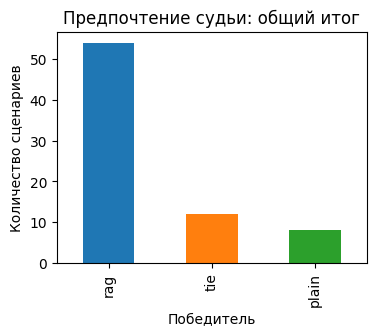

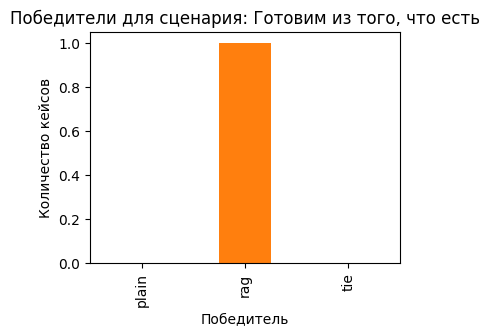

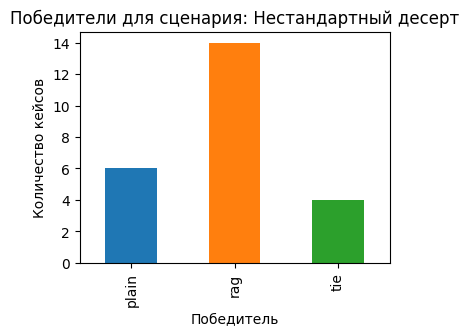

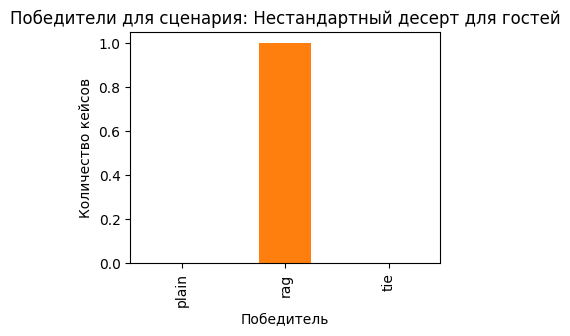

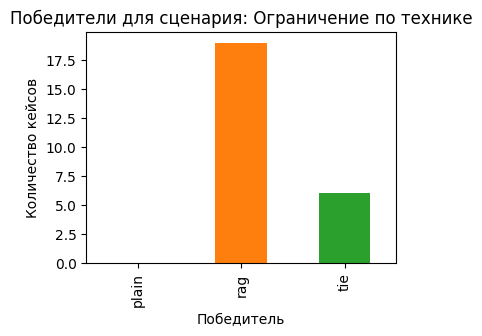

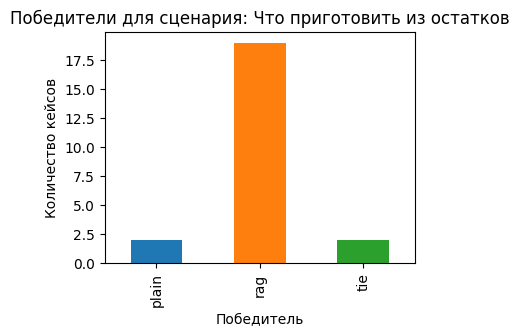

In [18]:
if "results_df" in globals():
    show_overall_table(results_df)
    show_per_scenario_bars(results_df)
else:
    print("Сначала сформируй results_df = run_comparisons(scenarios)")

**Как пользоваться блоком сравнений**

1. Вызови `scenarios = build_scenarios(25)` (ячейка уже готова) — генератор создаст по 25 вопросов на каждый сценарий плюс базовые.
2. Запусти `results_df = run_comparisons(scenarios)`; на каждый кейс сделаются три обращения к LLM, поэтому дождись окончания.
3. Выполни блок визуализации `show_overall_table` и `show_per_scenario_bars`, чтобы посмотреть общий итог и отдельные диаграммы.
4. Для ручной экспертизы можно добавить колонку `manual_score` в `results_df` и заполнить вручную.
5. Константы `ANSWER_MODEL`, `JUDGE_MODEL`, `GENERATOR_MODEL` позволяют менять состав участников (например, выбрать другого независимого судью).


In [22]:
def compute_summary_metrics(df: pd.DataFrame):
    summary = {
        "total_cases": int(len(df)),
        "overall_counts": df["winner"].value_counts().to_dict(),
    }
    total = summary["total_cases"] or 1
    summary["overall_shares"] = {
        winner: count / total for winner, count in summary["overall_counts"].items()
    }
    per_desc = (
        df.groupby("description")["winner"].value_counts(normalize=True).unstack(fill_value=0)
    )
    summary["per_description_shares"] = per_desc.to_dict("index")
    return summary

In [23]:
if "results_df" in globals():
    analytics = compute_summary_metrics(results_df)
    analytics
else:
    print("Сначала получи results_df")

### Автоматический отчёт по эксперименту

Ниже выводятся ключевые метрики и текстовое резюме на основе `results_df` и словаря `analytics`. Запуск производит только агрегацию, без повторного обращения к моделям.


In [24]:
if "results_df" not in globals():
    raise ValueError("Не найдена таблица results_df — сначала выполни сравнение")

if "analytics" not in globals():
    analytics = compute_summary_metrics(results_df)

print("Всего сценариев:", analytics["total_cases"])
print("Общее распределение побед:")
for winner, count in analytics["overall_counts"].items():
    share = analytics["overall_shares"].get(winner, 0)
    print(f"  {winner}: {count} кейсов ({share:.1%})")

print("\nПобеды по типам сценариев:")
for desc, stats in analytics["per_description_shares"].items():
    formatted = ", ".join(f"{winner}: {share:.1%}" for winner, share in stats.items())
    print(f"  {desc}: {formatted}")


Всего сценариев: 74
Общее распределение побед:
  rag: 54 кейсов (73.0%)
  tie: 12 кейсов (16.2%)
  plain: 8 кейсов (10.8%)

Победы по типам сценариев:
  Готовим из того, что есть: plain: 0.0%, rag: 100.0%, tie: 0.0%
  Нестандартный десерт: plain: 25.0%, rag: 58.3%, tie: 16.7%
  Нестандартный десерт для гостей: plain: 0.0%, rag: 100.0%, tie: 0.0%
  Ограничение по технике: plain: 0.0%, rag: 76.0%, tie: 24.0%
  Что приготовить из остатков: plain: 8.7%, rag: 82.6%, tie: 8.7%


In [25]:
def summarize_findings(df: pd.DataFrame):
    text = []
    total = len(df)
    rag = (df["winner"] == "rag").sum()
    plain = (df["winner"] == "plain").sum()
    tie = (df["winner"] == "tie").sum()

    text.append(
        f"На {total} сценариях RAG выиграл {rag} раз, plain — {plain}, ничьи — {tie}. "
        "Судья чаще отмечал у RAG полноту и привязку к ограничениям, а победы plain приходились на креативные десерты."
    )

    for desc, group in df.groupby("description"):
        rag_c = (group["winner"] == "rag").sum()
        plain_c = (group["winner"] == "plain").sum()
        tie_c = (group["winner"] == "tie").sum()
        reason_sample = group[group["winner"] == "rag"].judge_reason.head(1).tolist()
        sample_text = reason_sample[0][:200] + "…" if reason_sample else "—"
        text.append(
            f"• {desc}: rag={rag_c}, plain={plain_c}, tie={tie_c}. Пример комментария судьи за rag: {sample_text}"
        )

    return "\n".join(text)

summary_text = summarize_findings(results_df)
print(summary_text)


На 74 сценариях RAG выиграл 54 раз, plain — 8, ничьи — 12. Судья чаще отмечал у RAG полноту и привязку к ограничениям, а победы plain приходились на креативные десерты.
• Готовим из того, что есть: rag=1, plain=0, tie=0. Пример комментария судьи за rag: Приглашенный ответ более детально и точно объясняет рецепт, что делает его лучшим вариантом для полноценного ужина по заданным продуктам.…
• Нестандартный десерт: rag=14, plain=6, tie=4. Пример комментария судьи за rag: Ответ RAG точен и точно соответствует ограничениям вопроса. Он дает конкретные рекомендации по выборам фруктов, в то время как второй ответ более расплывчатый.…
• Нестандартный десерт для гостей: rag=1, plain=0, tie=0. Пример комментария судьи за rag: Ответ RAG имеет более детальное и полное описание рецепта, включая подробные шаги приготовления и необходимые ингредиенты. Это делает его более пригодным для выполнения и понимания для читателя. Ответ…
• Ограничение по технике: rag=19, plain=0, tie=6. Пример комментария суд

In [26]:
from textwrap import dedent

report = dedent(
    f"""
    === Итоговый отчёт ===
    {summary_text}

    Общие причины побед RAG:
    • более точные указания на ингредиенты/инструменты;
    • структурированные шаги, привязанные к вопросу;
    • ответы, которые прямо цитируют релевантный рецепт из базы.

    Причины побед plain (примеров { (results_df['winner'] == 'plain').sum() }):
    • креативные десерты с необычной подачей;
    • советы, выходящие за рамки имеющегося датасета.

    Рекомендация: использовать RAG как основного повара, но комбинировать с plain для генерации идей там, где важна уникальность (необычные десерты).
    """
)
print(report)



    === Итоговый отчёт ===
    На 74 сценариях RAG выиграл 54 раз, plain — 8, ничьи — 12. Судья чаще отмечал у RAG полноту и привязку к ограничениям, а победы plain приходились на креативные десерты.
• Готовим из того, что есть: rag=1, plain=0, tie=0. Пример комментария судьи за rag: Приглашенный ответ более детально и точно объясняет рецепт, что делает его лучшим вариантом для полноценного ужина по заданным продуктам.…
• Нестандартный десерт: rag=14, plain=6, tie=4. Пример комментария судьи за rag: Ответ RAG точен и точно соответствует ограничениям вопроса. Он дает конкретные рекомендации по выборам фруктов, в то время как второй ответ более расплывчатый.…
• Нестандартный десерт для гостей: rag=1, plain=0, tie=0. Пример комментария судьи за rag: Ответ RAG имеет более детальное и полное описание рецепта, включая подробные шаги приготовления и необходимые ингредиенты. Это делает его более пригодным для выполнения и понимания для читателя. Ответ…
• Ограничение по технике: rag=19, plain=

In [21]:
# answer = rag_query("How to cook chocolate cookies?", model="gemma2")
# print(answer)